# AI coursework


using the mush.csv dataset.
we will do binary classification with the three algorithms

- tree decision thing
- logistic regression
- k nearest thing


## Used Libraries

In [44]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import scipy as sc
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


from sklearn.svm import SVC

import scipy.stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score


In [45]:
dataset = pd.read_csv('./mush.csv')
print("data set : ", dataset.shape)

data set :  (8416, 23)


In [46]:
#Code for confusion matrix generation.
def eval_confusion(model, X_test, y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    from sklearn.metrics import plot_confusion_matrix

    conf_matrix = confusion_matrix(y_test, y_pred)
    matrix = plot_confusion_matrix(model, X_test, y_test, cmap = plt.cm.Purples)
    matrix.ax_.set_title('Confusion Matrix', color="black")
    plt.xlabel('Predicted Label', color="black")
    plt.ylabel('True Label', color="black")
    plt.gcf().axes[0].tick_params(colors="black")
    plt.gcf().axes[1].tick_params(colors="black")
    plt.show()

Now that we have imported the (extended) dataset into the Pandas Dataframe `dataset` we can do some EDA
# Exploratory Data Analysis 

In [47]:
edible = dataset[dataset['edibility']=='EDIBLE'].shape[0]
poison = dataset[dataset['edibility']=='POISONOUS'].shape[0]
print("edible count: "+str(edible) + "(" + str(edible/dataset.shape[0] * 100) + "%)")
print("poison count: "+str(poison) + "(" + str(poison/dataset.shape[0] * 100) + "%)")

edible count: 4488(53.326996197718636%)
poison count: 3928(46.67300380228137%)


## Frequency Counts for each attribute

In [48]:
columns = dataset.columns
"""
for col in columns:
    #series = dataset[col].value_counts()
    #print(series)
    #print("null values = " + str(dataset[col].isnull().sum()))
    #print("\n")
    
    sns.set_theme()
    plot = sns.countplot(x=dataset[col], order=dataset[col].value_counts(ascending=False).index, palette = "PuBuGn_d");
    
    
    abs_values = dataset[col].value_counts(ascending=False)
    lbls = [f'{p[0]}' for p in zip(abs_values)]
    plot.bar_label(container=plot.containers[0], labels=lbls)
    
    plot.set_xticklabels(plot.get_xticklabels(), rotation=40)

    plt.show()
    if col == "bruises?":
        col = "bruises"
    
    # To save new copies of the attribute Bar charts
    # plot.figure.savefig("Graphs/FrequencyBar/"+col+".png", bbox_inches='tight')
"""  
    

'\nfor col in columns:\n    #series = dataset[col].value_counts()\n    #print(series)\n    #print("null values = " + str(dataset[col].isnull().sum()))\n    #print("\n")\n    \n    sns.set_theme()\n    plot = sns.countplot(x=dataset[col], order=dataset[col].value_counts(ascending=False).index, palette = "PuBuGn_d");\n    \n    \n    abs_values = dataset[col].value_counts(ascending=False)\n    lbls = [f\'{p[0]}\' for p in zip(abs_values)]\n    plot.bar_label(container=plot.containers[0], labels=lbls)\n    \n    plot.set_xticklabels(plot.get_xticklabels(), rotation=40)\n\n    plt.show()\n    if col == "bruises?":\n        col = "bruises"\n    \n    # To save new copies of the attribute Bar charts\n    # plot.figure.savefig("Graphs/FrequencyBar/"+col+".png", bbox_inches=\'tight\')\n'

## Redundant attribute
If we go through, we can see that attribute #16 'veil-type' is a useless attribute since all $8416$ rows have the same value. So, we can remove this column since it will do nothing but take up time. Now, we are down to 22 columns (including the `edibility` column)

In [49]:
dataset = dataset.drop(['veil-type'], axis = 1)

## Missing data
Here we have printed out the the sums of all the values in each column, as well as a count of the number of null values in each. 
Since the null values in attribute $#11$ are represented by the string `'?'`, they are not registered as a null value by pandas.

In [50]:
dataset = dataset.replace("?", np.NaN)
dataset.isnull().sum()

edibility                      0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises?                       0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

Now that the missing values have been correctly replaced with the Pandas `NaN` indicator, we can deal with thees datapoints how we see fit.


Two options would be to either delete the column with the missing data (`stalk-root` attribute $#11$) or delete the rows with the missing data

By deleting the Column with the missing data, we will still have $8416$ entries, and only $21$ columns to work with (including edibility)

On the other hand, by deleting the Rows with the missing values, we will keep $22$ columns but will go down to $5936$ columns

In [51]:
# To delete rows with missing data
# dataset.dropna(axis=0)

# To delete attribute #11
dataset = dataset.dropna(axis=1)
dataset.shape


(8416, 21)

Now, we can do some more EDA, here we are going to create cross tabluations of each attribute with the output.

## Cross Tabulations and $\chi ^2$ tests

Additionally, we have calculated the $\chi^2$-test for independence $p$ values for each attribute against the output edibility

Reminder that the chi squared test is used for a hypothesis test. In this case, the Hypothesis $H_0$ will be "attribute 1 and attribute 2 are independent", when our $p$ values are lower than 0.05, we can be 95% sure that $H_0$ is false.

In [52]:
from scipy.stats import chi2_contingency

chisquaredvalues = pd.DataFrame(np.zeros((dataset.shape[1], 1)), columns = ['p value'], index = dataset.columns)
min = 10
max = 0

for col1 in dataset.columns:
    col2 = 'edibility'
    crosstab = pd.crosstab(dataset[col2], dataset[col1])
    chi2, p, dof, ex = chi2_contingency(crosstab)
    chisquaredvalues.at[col1, 'p value'] =  p

    if p>max:
        max = p
    if p<min:
        min = p

    """
    sns.set_theme()
    # generate cross tabulations with edibility
    heatplot = sns.heatmap(crosstab, annot = True, fmt = "d")
    heatplot.set_xticklabels(heatplot.get_xticklabels(), rotation=45)
    heatplot.set_yticklabels(heatplot.get_yticklabels(), rotation=45)
    plt.show()

    # To save new copies of the crosstab heatmap
    if col1 == "bruises?":
        label = "bruises"
    else:
        label = col1
    heatplot.figure.savefig("Graphs/CrossTabulations/"+label+"x"+col2+".png", bbox_inches='tight')
 """   
    
print(chisquaredvalues)


                                p value
edibility                  0.000000e+00
cap-shape                 3.187210e-103
cap-surface                5.996665e-76
cap-color                  1.168726e-90
bruises?                   0.000000e+00
odor                       0.000000e+00
gill-attachment            5.401073e-26
gill-spacing              4.427957e-271
gill-size                  0.000000e+00
gill-color                 0.000000e+00
stalk-shape                3.161053e-29
stalk-surface-above-ring   0.000000e+00
stalk-surface-below-ring   0.000000e+00
stalk-color-above-ring     0.000000e+00
stalk-color-below-ring     0.000000e+00
veil-color                 6.088534e-39
ring-number                2.630475e-79
ring-type                  0.000000e+00
spore-print-color          0.000000e+00
population                 0.000000e+00
habitat                    0.000000e+00


since the $p$ values for every attribute remaining is less than less than $0.05$, with the highest value being $5.4e-26$, we can see that there is enough sufficient evidence to reject $H_0$, so, all of these attributes must be dependent on the edibility, and, more importantly, the edibility is dependent on each of these attributes, meaning using them to train our mahine learning algorithms should work well.

## Removing Duplicates
We can remove some duplicate rows.

In [53]:
print(dataset.shape)
dataset = dataset.drop_duplicates()
print(dataset.shape)

(8416, 21)
(8124, 21)


Now that we have fixed up our dataset, we must now do some Data Transformation
# Data Transformation
all of our $22$ attributes can be divided into 3 categories; Ordinal, Nominal and Binary Nominal attributes

Binary Nominal Attributes with only two values only require one binary flag (0,1) to represent it's data.
- №0 'edibility': {'EDIBLE':1,'POISONOUS':0}
- №4 'bruises?' : {'BRUISES':1,'NO':0}
- №6 'gill-attachment' : {'FREE':0,'ATTACHED':1}
- №8 'gill-size' : {'BROAD':0,'NARROW':1}
- №10 'stalk-shape' : {'ENLARGING':0,'TAPERING':1}


Ordinal attributes can be use a mapping dictionary to map each category to an integer.
- №7 'gill-spacing' : {'CLOSE':0,'CROWDED':1,'DISTANT':2}
- №18 'ring-number' : {'NONE':0,'ONE':1,'TWO':2}
- №21 'population' : {'ABUNDANT':6,'CLUSTERED':5,'NUMEROUS':4,'SCATTERED':3,'SEVERAL':2,'SOLITARY':1}

And the rest are Nominal chategorical attributes so will likely have to be one-hot encoded




In [54]:
# Binary Nominal Attributes
edibility_map_dict = {"EDIBLE":1,"POISONOUS":0}
bruises_map_dict = {"BRUISES":1,"NO":0}
gill_attachment_map_dict = {"FREE":0,"ATTACHED":1}
gill_size_map_dict = {'BROAD':0,'NARROW':1}
stalk_shape_map_dict = {'ENLARGING':0,'TAPERING':1}
# Ordinal Attributes
gill_spacing_map_dict = {'CLOSE':0,'CROWDED':1,'DISTANT':2}
ring_number_map_dict = {'NONE':0,'ONE':1,'TWO':2}
population_map_dict = {'ABUNDANT':6,'CLUSTERED':5,'NUMEROUS':4,'SCATTERED':3,'SEVERAL':2,'SOLITARY':1}

mapping_dicts = [edibility_map_dict, bruises_map_dict, gill_attachment_map_dict, gill_size_map_dict, stalk_shape_map_dict, gill_spacing_map_dict, ring_number_map_dict, population_map_dict]
mapping_columns = ['edibility','bruises?','gill-attachment','gill-size','stalk-shape','gill-spacing','ring-number','population']

for i in range(len(mapping_columns)):
    dataset[mapping_columns[i]] = dataset[mapping_columns[i]].map(mapping_dicts[i])
    
onehot_columns = ['cap-shape','cap-surface','cap-color','odor','gill-color','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-color','ring-type','spore-print-color','habitat']
cleanDataset = pd.get_dummies(dataset, columns=onehot_columns)

Now, the dataset is cleaned, and stored in the new Pandas DF `cleanDataset`

In [55]:
cleanDataset.shape

(8124, 100)

In [56]:
# cleanDataset.info()

In [57]:
cleanDataset.describe()

,edibility,bruises?,gill-attachment,gill-spacing,gill-size,stalk-shape,ring-number,population,cap-shape_BELL,cap-shape_CONICAL,...,spore-print-color_PURPLE,spore-print-color_WHITE,spore-print-color_YELLOW,habitat_GRASSES,habitat_LEAVES,habitat_MEADOWS,habitat_PATHS,habitat_URBAN,habitat_WASTE,habitat_WOODS
count,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,...,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000
mean,0.517971,0.415559,0.025849,0.161497,0.309207,0.567208,1.069424,2.355982,0.055638,0.000492,...,0.005908,0.293944,0.005908,0.264402,0.102413,0.035943,0.140817,0.045298,0.023634,0.387494
std,0.499708,0.492848,0.158695,0.368011,0.462195,0.495493,0.271064,1.252082,0.229235,0.022185,...,0.076644,0.455595,0.076644,0.441041,0.303209,0.186159,0.347854,0.207969,0.151914,0.487208
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,6.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now that all our data is clean, encoded and ready to go, lets get started by splitting the data up into all the relevant groups.

# Data Splitting

If we assume we will be using a simple data splitting method, we simply need to have both the $X$ and $y$ for training aand testing

In [58]:
y = cleanDataset['edibility'].values
big_X = cleanDataset.iloc[:, 1:].values

print("y: "+str(y.shape) + "\nX: "+str(big_X.shape))

y: (8124,)
X: (8124, 99)


## Dimensionality Reduction
Do this after you have separated X from y. then we can reduce the number of dimensions 

## Data is scaled


In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(big_X)

big_X = scaler.transform(big_X)

[0.09334823 0.16563011 0.23398327 0.2864628  0.33312077 0.37203261
 0.40736679 0.43981687 0.46211254 0.4831915  0.50365351 0.52359756
 0.54016991 0.55548421 0.57025705 0.58455936 0.59775198 0.61062356
 0.62335384 0.6353884  0.64711551 0.65850019 0.66972568 0.68085245
 0.69175293 0.70262476 0.71324887 0.72383033 0.73416897 0.74439077
 0.75455182 0.76471286 0.77483381 0.78494058 0.79473966 0.80435809
 0.81375071 0.82301616 0.83177261 0.84050109 0.84880625 0.8570539
 0.86516985 0.87296689 0.88054877 0.88779901 0.89480372 0.90158735
 0.90827664 0.9148437  0.9210266  0.92704299 0.93275899 0.93810232
 0.94334334 0.94846095 0.95332733 0.95797713 0.96212289 0.96620448
 0.9699663  0.97354174 0.97694108 0.98023273 0.98325091 0.985901
 0.98851784 0.99067532 0.99278709 0.99458699 0.99635576 0.99780134
 0.99875104 0.99919766 0.99955193 0.99977648 0.99988267 0.99997843
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.

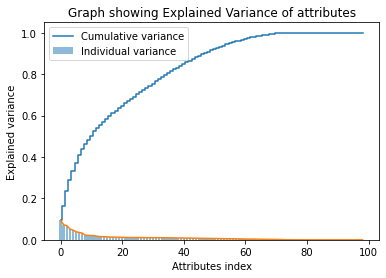

In [85]:
from sklearn.decomposition import PCA

pca = PCA()
temp_X = pca.fit_transform(big_X)

variances = pca.explained_variance_ratio_
cum_sum_variances = np.cumsum(variances)
print(cum_sum_variances)

plt.bar(range(0,99), variances, alpha = 0.5, align = 'center', label='Individual variance')
plt.step(range(0,99), cum_sum_variances, where = 'mid', label = 'Cumulative variance')
plt.ylabel('Explained variance')
plt.xlabel('Attributes index')
plt.legend(loc='best')
plt.title('Graph showing Explained Variance of attributes')


variance_plot = sns.lineplot(data = variances, markers = True)
plt.show()

In [61]:
pca = PCA(n_components=10, random_state=1)
X = pca.fit_transform(big_X)
X.shape

(8124, 10)

Now we have the columns in their correct places and the dimensions of X reduced, lets shuffle them around, and then split them into the correct Test and Train sets.
Note that the ratio of columns assigned to the train set and the test set can be changed by changing the variable `train_ratio` 

We split the data using a stratified splitter into train and tests. But have also shuffled the entire X,y dataset Dataframes. This is so that they can be used for cross validation.

We have the version of the splitter to **stratify** the random splitting. This way the proportions of examples in both classes for y is maintained in both splits 

In [62]:
from sklearn.model_selection import train_test_split
#test_ratio = 0.2
test_ratio = 0.3


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio, random_state = 0, stratify = y)

indices = np.arange(cleanDataset.shape[0])
rng = np.random.RandomState(0)
permuted_indices = rng.permutation(indices)
X = X[permuted_indices]
y = y[permuted_indices]


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5686, 10) (5686,)
(2438, 10) (2438,)


In [63]:
def Counts(ArrayToCount):
    vals, count = np.unique(ArrayToCount, return_counts=True)
    return (dict(zip(vals, count)))

print(Counts(y_test))
print(Counts(y_train))

{0: 1175, 1: 1263}
{0: 2741, 1: 2945}


Now we have split the data into all the seperate parts. 
- `X_train`
- `X_test`
- `y_train`
- `y_test`

**note** that these can now be used for training and testing, although if any alterations happen during the algorithms themselves, be sure to copy these into a local variable so that in the end we are able to run all of the algorithms with one simple click.

# Logistic Regression



In [64]:
LogReg = LogisticRegression(solver='lbfgs', max_iter=1000) 
LogReg.fit(X_train, y_train)
y_pred=LogReg.predict(X_test)
train_acc = LogReg.score(X_train, y_train) 
print("The Accuracy for Training Set is {}".format(train_acc*100)) 
test_acc = accuracy_score(y_test, y_pred) 
print("The Accuracy for Test Set is {}".format(test_acc*100)) 
print("The Precision for Test Set is {}".format(precision_score(y_test, y_pred)*100))
print(classification_report(y_test, y_pred))

scores = cross_val_score(LogReg, X, y, cv=10)

print('Cross-Validation scores: {}'.format(scores))
print('Average score: {}'.format(np.mean(scores)))


The Accuracy for Training Set is 94.03798804080196
The Accuracy for Test Set is 94.298605414274
The Precision for Test Set is 93.16436251920123
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1175
           1       0.93      0.96      0.95      1263

    accuracy                           0.94      2438
   macro avg       0.94      0.94      0.94      2438
weighted avg       0.94      0.94      0.94      2438

Cross-Validation scores: [0.94341943 0.94464945 0.94464945 0.93849938 0.9273399  0.94581281
 0.94704433 0.95320197 0.94827586 0.93596059]
Average score: 0.9428853180157418


In [65]:
#grid search
C = np.logspace(0, 4, num=10)
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga']
hyperparameters = dict(C=C, penalty=penalty, solver=solver)
logistic =LogisticRegression()
gridsearch = GridSearchCV(logistic, hyperparameters, cv=10)
best_model_grid = gridsearch.fit(X_train,y_train)
print(best_model_grid.best_params_)

{'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}


In [66]:
LogReg2=LogisticRegression(C=1,penalty="l1",solver='saga')
LogReg2.fit(X_train,y_train)

scores = cross_val_score(LogReg2, X, y, cv=10)

print('Cross-Validation scores: {}'.format(scores))
print('Average score: {}'.format(np.mean(scores)))

Cross-Validation scores: [0.94218942 0.94464945 0.94464945 0.93849938 0.9273399  0.94581281
 0.94704433 0.95320197 0.94827586 0.93472906]
Average score: 0.9426391640763698


In [67]:
#random search
C = np.logspace(0, 4, num=10)
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga']
hyperparameters = dict(C=C, penalty=penalty, solver=solver)
logistic =LogisticRegression()

randomizedsearch = RandomizedSearchCV(logistic, hyperparameters)
best_model_random = randomizedsearch.fit(X_train,y_train)
print(best_model_random.best_estimator_)

LogisticRegression(C=7.742636826811269, penalty='l1', solver='saga')


In [68]:
LogReg3=LogisticRegression(C=1, penalty='l1', solver='liblinear')

# LogReg3.fit(X_train,y_train)

scores = cross_val_score(LogReg3, X, y, cv=10)

print('Cross-Validation scores: {}'.format(scores))
logregBestScore = np.mean(scores)
print('Average score: {}'.format(logregBestScore))



LogRegPredictions = cross_val_predict(LogReg3, X, y, cv=10)
print(classification_report(y, LogRegPredictions))



Cross-Validation scores: [0.94218942 0.94464945 0.94464945 0.93849938 0.9273399  0.94704433
 0.94704433 0.95320197 0.94827586 0.93472906]
Average score: 0.9427623167857295
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3916
           1       0.93      0.96      0.95      4208

    accuracy                           0.94      8124
   macro avg       0.94      0.94      0.94      8124
weighted avg       0.94      0.94      0.94      8124



# K-nearest callable function
neighbors default is 5, so this is a reasonable value to pass in


In [69]:
from sklearn.neighbors import KNeighborsClassifier
def knearest(X_train, y_train, X_test, neighbors, distance_metric):
    from sklearn.neighbors import KNeighborsClassifier
    kNeighbors = KNeighborsClassifier(n_neighbors=neighbors, metric=distance_metric)
    kNeighbors.fit(X_train, y_train)

    y_pred = kNeighbors.predict(X_test)
    return y_pred



knearest_pred = knearest(X_train, y_train, X_test, 2, 'euclidean')
# {'n_neighbors':{1,2,3,4,5,6,7,8,9,10},'metric':{'euclidean','manhattan','minkowski','chebyshev','wminkowski','seuclidean','mahalanobis'}, 'algorithm':{'ball_tree','kd_tree','brute','auto'}}

print (knearest_pred)

test_acc_k_nearest = accuracy_score(y_test, knearest_pred) 
print("The Accuracy for Test Set is {}".format(test_acc_k_nearest*100)) 

# Generate classification report 
print(classification_report(y_test, knearest_pred))






[0 0 1 ... 1 1 1]
The Accuracy for Test Set is 100.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



I will now attempt to do some hyper parameter tuning to find the best algirhtms and whatnots to perform the algorithm with. then also do a cross validation using these to get a good result indicative of the accuracy of the algorithm.

In [70]:
knnModel = KNeighborsClassifier()
knnHyperParams = {'n_neighbors':(1,2,3,4,5,6,7,8,9,10),'metric':('euclidean','manhattan','minkowski','chebyshev')}
grid = GridSearchCV(knnModel, knnHyperParams, cv=10, scoring='accuracy',  return_train_score=False,verbose=1)
grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)



bestKnn = KNeighborsClassifier(n_neighbors = grid_search.best_params_['n_neighbors'], metric = grid_search.best_params_['metric'])
knnScores = cross_val_score(bestKnn, X, y, cv=10)

print('Cross-Validation scores: {}'.format(knnScores))
knnBestScore = (np.mean(knnScores))
print('Average score: {}'.format(knnBestScore))




knnPredictions = cross_val_predict(bestKnn, X, y, cv=10)
print(classification_report(y, knnPredictions))

#eval_confusion(bestKnn, X, y, knnPredictions)


Fitting 10 folds for each of 40 candidates, totalling 400 fits
{'metric': 'euclidean', 'n_neighbors': 1}
1.0
Cross-Validation scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3916
           1       1.00      1.00      1.00      4208

    accuracy                           1.00      8124
   macro avg       1.00      1.00      1.00      8124
weighted avg       1.00      1.00      1.00      8124



#### Masha's section


# Decision Tree function

In [71]:
def decision_tree_func(X_train, y_train, X_test, y_test):
    #Libraries used : 
    from sklearn.tree import DecisionTreeClassifier
    ###
    from sklearn.metrics import classification_report
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    

    pipeline = Pipeline([
        ('clf', DecisionTreeClassifier(criterion = 'entropy'))
    ])

    #Limiting the depth of the tree to be used to prevent overfitting.
    ######With [clf__max_depth': (5, 6)] we aleady get 1.00 for f1 score.
    ######f1 starts going below 1.00 at ['clf__max_depth': (4, 5)]. At this setting f-1 is 0.99
    parameters = {
        'clf__max_depth': (5, 15, 20, 25, 30),
        'clf__min_samples_split': (2, 3, 4),
        'clf__min_samples_leaf': (1, 2, 3, 4)
    }

    # parameters = {
    #     'clf__max_depth': (200, 300),
    #     'clf__min_samples_split': (5, 6),
    #     'clf__min_samples_leaf': (5, 6)
    # }

    #Creating the machine learning model with decision trees using GridSearchCV
    grid_search_model = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1')
    grid_search_model.fit(X_train, y_train)
    
    print('Best score: %0.3f' % grid_search_model.best_score_)
    print('Best parameters set:')
    best_parameters = grid_search_model.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print('t%s: %r' % (param_name, best_parameters[param_name]))
    decision_tree_predictions = grid_search_model.predict(X_test)

    #Priting model evaluation based on its f1 score.
    print(classification_report(y_test, decision_tree_predictions))
    #Returning the model and its prediction. To be used in performance analysis.
    return grid_search_model, decision_tree_predictions

### Setting up X and y with the original dataset.
To be used in comparison of machine learning model performance over original data and clean data.

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
#(for OneHotEncoding)
import numpy as np
from sklearn.preprocessing import OneHotEncoder

#Creating a dataframe called "df" using the data from mushrooms.csv
df = pd.read_csv('./mush.csv')

#Creating a list of all column_names from the 1st row in the dataset.
#Used in OneHotEncoding
column_names = "edibility,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat"
column_names_list = column_names.split(",")

#Creating a new dataframe X by copying the original dataframe into it.
X_orig = df.copy()
#Removing the answer column from the input dataframe X.
#This is to prevent the model from learning the answers.
del X_orig["edibility"]

#For future check - to see if OneHotEncoding has worked.
#print("Old size of X: ", X.shape)

#Generating a 2D array called unique_variable_values.
#It will contain arrays in such way, that each array with index i has all unique variable values of column i in the dataset (for 0 <= i < number of columns).
unique_variable_values = []
first = True
for col in df:
    if first:
        first = False
        continue
    unique_variable_values.append(list(df[col].unique()))    
#To check if unique_variable_values array was generated correctly
#print(unique_variable_values)

#Using OneHotEncoder on X, creating a representation of our mushroom data set (contains nominal data only) that can be used in machine learning.
ohe = OneHotEncoder(categories = unique_variable_values)
X_new_orig = ohe.fit_transform(X_orig).toarray()
#To check if OneHotEncoding has worked.
#print("New X shape: ", X_new.shape)

#Setting up y to contain the answer column. In our case each row will either say "Edible" or "Poisonous"
y_orig = df["edibility"]

#Performing a test-train split on y and X.
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_new_orig, y_orig, shuffle=True)
#Setting shuffle to True to make sure the data is split randomly.
#This prevents unintentional bias 

In [73]:
#Using the decision tree model on original data
decision_tree_model_orig, decision_tree_predictions_orig = decision_tree_func(X_train_orig, y_train_orig, X_test_orig, y_test_orig)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


Best score: nan
Best parameters set:
tclf__max_depth: 5
tclf__min_samples_leaf: 1
tclf__min_samples_split: 2
              precision    recall  f1-score   support

      EDIBLE       1.00      1.00      1.00      1119
   POISONOUS       1.00      1.00      1.00       985

    accuracy                           1.00      2104
   macro avg       1.00      1.00      1.00      2104
weighted avg       1.00      1.00      1.00      2104



C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


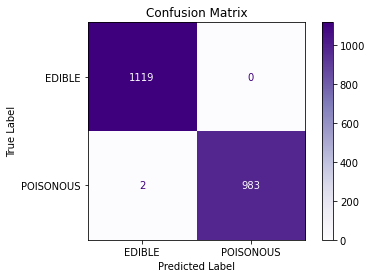

In [74]:
eval_confusion(decision_tree_model_orig, X_test_orig, y_test_orig, decision_tree_predictions_orig)

In [75]:
#Using the decision tree model on clean data
decision_tree_model, decision_tree_predictions = decision_tree_func(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best score: 0.997
Best parameters set:
tclf__max_depth: 20
tclf__min_samples_leaf: 1
tclf__min_samples_split: 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


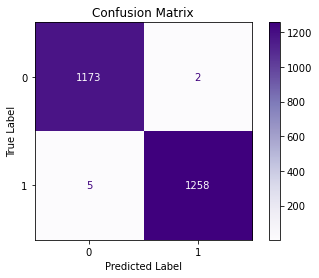

In [76]:
eval_confusion(decision_tree_model, X_test, y_test, decision_tree_predictions)

# Random Forest function

In [77]:
def random_forest_func(X_train, y_train, X_test, y_test):
    #Libraries used :
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV

    pipeline = Pipeline([
        ('clf', RandomForestClassifier(criterion = 'entropy'))
    ])

    #Limiting the depth of the tree to be used to prevent overfitting.
    #While experimenting with decison_tree_procedure(), I have already found that [clf__max_depth': (5, 6)] is optimal for our dataset.
    #This remains true for the random forest model as well. 5 is still the optimal depth - gives us no overfitting and no underfitting.
    
    #With 10 estimators we already get f1 in the range of 0.99 and 1.00. To reduce the computation time, I checked f1 with different enstimators used.
    #Having 9 estimators results in f1 = [0.98, 0.99]
    #Setting clf__n_estimators to 5 gives an average f1 of 0.97.
    #Increasing the the number of estimators to 11 also gave f1 betwee 0.99 and 1.00. However, in this case the 1.00 could be seen more often, compared to the use of 10 estimators.
    #Therefore, it is best to use 11 estimators with original data - to not harm the accuracy and reduce computational resourses.
    parameters = {
        #'clf__max_depth': (3, 4, 5),
        'clf__n_estimators': (11, 15, 20),
        # 'clf__max_depth': (65, 6),
        'clf__max_depth': (6, 7),
        'clf__min_samples_split': (2, 3),
        'clf__min_samples_leaf': (1, 2, 3)
    }

    #Creating the machine learning model with decision trees using GridSearchCV
    random_forest_model = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1')
    random_forest_model.fit(X_train, y_train)
    best_parameters = random_forest_model.best_estimator_.get_params()
    print('Best score: %0.3f' % random_forest_model.best_score_)
    print('Best parameters set:')
    for param_name in sorted(parameters.keys()):
        print('t%s: %r' % (param_name, best_parameters[param_name]))
    random_forest_predictions = random_forest_model.predict(X_test)

    #Priting model evaluation based on its f1 score.
    print(classification_report(y_test, random_forest_predictions))
    return random_forest_model, random_forest_predictions

In [78]:
#Using the random forest model on original data
random_forest_model_orig, random_forest_predictions_orig = random_forest_func(X_train_orig, y_train_orig, X_test_orig, y_test_orig)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best score: nan
Best parameters set:
tclf__max_depth: 6
tclf__min_samples_leaf: 1
tclf__min_samples_split: 2
tclf__n_estimators: 11
              precision    recall  f1-score   support

      EDIBLE       0.99      1.00      1.00      1119
   POISONOUS       1.00      0.99      0.99       985

    accuracy                           0.99      2104
   macro avg       1.00      0.99      0.99      2104
weighted avg       0.99      0.99      0.99      2104



C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


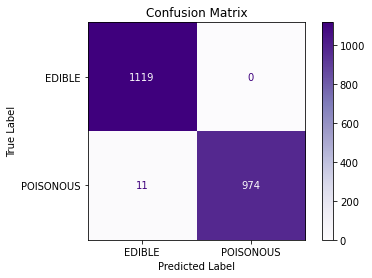

In [79]:
eval_confusion(random_forest_model_orig, X_test_orig, y_test_orig, random_forest_predictions_orig)

#### Random forest on Clean version of the data.

In [80]:
#Using the random forest model on clean data
random_forest_model, random_forest_predictions = random_forest_func(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best score: 0.999
Best parameters set:
tclf__max_depth: 7
tclf__min_samples_leaf: 1
tclf__min_samples_split: 2
tclf__n_estimators: 15
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1263

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


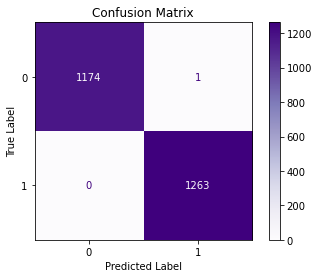

In [81]:
eval_confusion(random_forest_model, X_test, y_test, random_forest_predictions)

# Comparisons

[1.0, 0.9427623167857295]
          0         1
labels  knn    logreg
scores  1.0  0.942762


(0.9, 1.0)

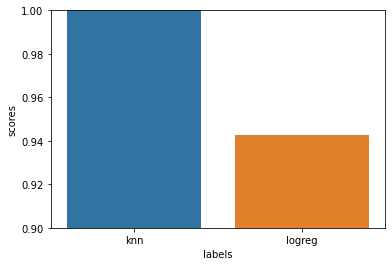

In [82]:
results = [knnBestScore, logregBestScore]
print(results)

df = pd.DataFrame({'labels':['knn', 'logreg'], 'scores':results})

print(df.T)

sns.barplot(x = df['labels'], y = df['scores'])
plt.ylim((0.9,1.0))